In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.feature_selection import SelectKBest
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from scipy.stats import gaussian_kde
from matplotlib.ticker import PercentFormatter
import shap
from adjustText import adjust_text
from sklearn.preprocessing import StandardScaler
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# Self-defined functions

In [2]:
def split_twins(selected_data):

    # Not all patients there have a twin, these may afect the accuracy of duplicate split

    Counts = Counter(selected_data['fid'])
    non_dup = [i for i in Counts if Counts[i] == 1] #Take those without a duplicated id out
    non_dup_df = selected_data[selected_data['fid'].isin(non_dup )]


    # Split them into 2 parts
    part_50_non_dup = non_dup_df.sample(frac = 0.5, random_state=0) 
    rest_50_non_dup = non_dup_df.drop(part_50_non_dup.index) 

    # Split those with duplicated fid into another dataframe

    diff = np.setdiff1d(selected_data.index.values,non_dup_df.index.values)
    dup_df = selected_data.loc[diff, :]


    # Split them into 2 too

    data1 = dup_df.loc[dup_df['fid'].duplicated(), :]
    diff = np.setdiff1d(dup_df.index.values,data1.index.values)
    data2 = dup_df.loc[diff, :]

    # Merge the dup and non_dup together

    data1 = pd.concat([data1, part_50_non_dup], ignore_index=True)
    data2 = pd.concat([data2, rest_50_non_dup], ignore_index=True)
    
    #Return the splitted data
    return data1, data2

def find_optimal_kmeans_clusters(data,
                                 max_k,
                                 figsize=(20, 15),
                                 titlesize=20,
                                 ticksize=15,
                                 labelsize=15):
    '''
    Function to plot the elbow plot and automatically find the optimal number of kmeans clusters for a word2vec model
    
    Parameters
        ----------
        data : a word2vec model
        
        max_k: maximum of number of kmeans clusters to loop through
        
        figsize: figure size
        
        textsize: annotation font size
        
        labelsize: X & Y axis label font size
        
        titlesize: title font size
        
        ticksize = X & Y tick size

    Returns
        -------
        An elbow plot of cluster number vs SSE
        
        The optimal number of KMeans cluster and its associated SSE
    '''
    print('Finding Optimal K for data shape- ', data.shape)
    iters = range(2, max_k + 1, 1)
    sse = {}
    for k in iters:
        kmeans = KMeans(n_clusters=k, init='k-means++',
                        random_state=13).fit(data)
        sse[k] = kmeans.inertia_
        #print('Fit {} clusters'.format(k))
    plt.figure(figsize=figsize)
    plt.plot(iters, list(sse.values()), marker='o')
    plt.xlabel('Cluster Centers', fontsize=labelsize)
    plt.xticks(iters, size=ticksize)
    plt.yticks(size=ticksize)
    plt.ylabel('SSE', fontsize=labelsize)
    plt.title('SSE by Cluster Center Plot', size=titlesize)
    kn = KneeLocator(
        range(1, max_k),
        list(sse.values()),
        curve='convex',
        direction='decreasing',
        interp_method='polynomial',
    )
    plt.scatter(kn.knee, sse[kn.knee], marker='+', s=500, c='black')
    plt.show()
    print('Rate of Change of Slope/Max Curvature at K= ', kn.knee)
    return kn.knee, sse[kn.knee]

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def winsorize(data):
    if data > 170:
        return 170
    else:
        return data

def add_pwv(data, pwv_data):
    try:
        pwv = pwv_data[pwv_data['iid']==data['iid']]['PWV.m.sec'].values[0]
    except:
        pwv = np.nan
    return pwv

def find_best_features(score_func, X_train, y_train, num_features=100):
    fs = SelectKBest(score_func=score_func, k=num_features)
    fs.fit(X_train, y_train)
    mask = fs.get_support() #list of booleans
    best = [] # The list of your K best features

    for bool, feature in zip(mask, X_train.columns):
        if bool:
            best.append(feature)
            
    return best

def winsorize_pwv(data):
    if data > 13:
        return 13
    else:
        return data

def plot_scatters(all_actuals, all_preds, mean_MAE, CI_MAE, mean_MAPE, CI_MAPE, mean_R2, CI_R2):
    actuals = np.array(all_actuals)
    predictions_SBP = np.array(all_preds)

    xy = np.vstack([predictions_SBP, actuals])
    z = gaussian_kde(xy)(xy)

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = predictions_SBP[idx],actuals[idx], z[idx]

    plt.figure(figsize=(12,7))
    plt.scatter(x, y, c=z, s=30, cmap='viridis', edgecolor=None)
    plt.plot([], [], ' ', label="MAE:{} +/- {}\nMAPE:{} +/- {}\nR2:{} +/- {}".format(mean_MAE, CI_MAE, mean_MAPE, CI_MAPE, mean_R2, CI_R2))
    plt.title('Actual values vs Predicted  values for SBP')
    plt.ylabel('Actual SBP')
    plt.xlabel('Prediction')
    plt.legend(loc="upper left")
    cbar = plt.colorbar()
    ticklabels = cbar.ax.get_ymajorticklabels()
    ticks = list(cbar.get_ticks())
    cbar.set_ticks([z.min(), z.max()])
    cbar.set_ticklabels(['Low Density', 'High Density'])
    plt.show()

def test_model_cross_validation(model, Features, n_splits, selected_data, names_data, target, output_SHAP=False, pics=True):
    
    Y = selected_data[target]
    X = selected_data.copy()
    groups=selected_data['fid']

    gss = GroupShuffleSplit(n_splits=n_splits, random_state=0)

    R2_tests = []
    R2_vals = []
    MAE_tests = []
    MAE_vals = []
    MAPE_tests = []
    MAPE_vals = []
    all_pred_test = []
    all_actuals_test = []
    all_pred_val = []
    all_actuals_val = []
    list_shap_values = []
    list_train_sets = []

    for train_index, test_index in gss.split(X, Y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        X_test, X_val = split_twins(X_test)

        y_train = X_train[target]
        X_train = X_train.drop([target],axis=1)

        y_test = X_test[target]
        X_test = X_test.drop([target],axis=1)

        y_val = X_val[target]
        X_val = X_val.drop([target],axis=1)

        model.fit(X_train[Features], y_train)
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train[Features])

        # For each fold we save the train_set index and the shap_values
        list_shap_values.append(shap_values)
        list_train_sets.append(train_index)

        # Predict and calculate the prediction scores
        y_pred_test = model.predict(X_test[Features])
        y_pred_val = model.predict(X_val[Features])
        R2_test = r2_score(y_test, y_pred_test)
        R2_val = r2_score(y_val, y_pred_val)
        MAE_test = mean_absolute_error(y_test, y_pred_test)
        MAE_val = mean_absolute_error(y_val, y_pred_val)
        MAPE_test = mean_absolute_percentage_error(y_test, y_pred_test)
        MAPE_val = mean_absolute_percentage_error(y_val, y_pred_val)
        
        R2_tests.append(R2_test)
        MAE_tests.append(MAE_test)
        MAPE_tests.append(MAPE_test)
        R2_vals.append(R2_val)
        MAE_vals.append(MAE_val)
        MAPE_vals.append(MAPE_val)
        
        all_pred_test.extend(y_pred_test)
        all_actuals_test.extend(y_test)
        
        all_pred_val.extend(y_pred_val)
        all_actuals_val.extend(y_val)

    # Calculate the average scores across Kfolds
    mean_MAE_test = np.round(np.mean(MAE_tests),3)
    CI_MAE_test = np.round(np.std(MAE_tests)*2,3)
    mean_R2_test = np.round(np.mean(R2_tests),3)
    CI_R2_test = np.round(np.std(R2_tests)*2,3)
    mean_MAPE_test = np.round(np.mean(MAPE_tests),3)
    CI_MAPE_test = np.round(np.std(MAPE_tests)*2,3)


    mean_MAE_val = np.round(np.mean(MAE_vals),3)
    CI_MAE_val = np.round(np.std(MAE_vals)*2,3)
    mean_R2_val = np.round(np.mean(R2_vals),3)
    CI_R2_val = np.round(np.std(R2_vals)*2,3)
    mean_MAPE_val = np.round(np.mean(MAPE_vals),3)
    CI_MAPE_val = np.round(np.std(MAPE_vals)*2,3)


    print('Test set: MAE = {} +/- {}, MAPE = {} +/- {}, R2 = {} +/- {}'.format(mean_MAE_test, CI_MAE_test, mean_MAPE_test, CI_MAPE_test, mean_R2_test, CI_R2_test))
    print('Validation set: MAE = {} +/- {}, MAPE = {} +/- {}, R2 = {} +/- {}'.format(mean_MAE_val, CI_MAE_val, mean_MAPE_val, CI_MAPE_val, mean_R2_val, CI_R2_val))
    
    if pics:
        print('---------------------------------------------------------------------------------')
        print('Test set')
        plot_scatters(all_actuals_test, all_pred_test, mean_MAE_test, CI_MAE_test, mean_MAPE_test, CI_MAPE_test, mean_R2_test, CI_R2_test)

        print('---------------------------------------------------------------------------------')
        print('Validation set')
        plot_scatters(all_actuals_val, all_pred_val, mean_MAE_val, CI_MAE_val, mean_MAPE_val, CI_MAPE_val, mean_R2_val, CI_R2_val)

    train_set = np.concatenate(list_train_sets,axis=0)
    shap_values = np.concatenate(list_shap_values,axis=0)

    # Bringing back variable names    
    X_SHAP = pd.DataFrame(X.loc[train_set],columns=Features)
    
    # Rename the metabolites
    di = {}
    for m in X_SHAP.columns[X_SHAP.columns.str.startswith('M')]:
        try:
            di[m] = names_data[names_data['metabolon.id']==m]['name'].values[0]
        except:
            di[m] = m
            
    X_SHAP_names = X_SHAP[Features].rename(columns=di)

    # We do not need to include family ID in our explanation
    try:
        X_SHAP_names = X_SHAP_names.drop('fid',axis=1)
        shap_values = np.array(pd.DataFrame(shap_values,columns=Features).drop('fid',axis=1))
    except:
        shap_values = np.array(pd.DataFrame(shap_values,columns=Features))

    # Plot the SHAP plot
    if pics:
        print('---------------------------------------------------------------------------------')
        print('SHAP plot')
        shap.summary_plot(shap_values, X_SHAP_names, max_display=50, show=False)
    if output_SHAP==True:
        return X_SHAP, shap_values

# Data preparation

## Load the original datasets

In [3]:
# Load the Twins data

data = pd.read_csv('C:\\Users\\tranq\\Desktop\\Project\\Twins\\ML_pfizer_metabolites_anon_11_03_2021.csv')

names_data = pd.read_csv('C:\\Users\\tranq\\Desktop\\Project\\Twins\\ML_metabolite_annotation_11_03_2021.csv')

batch_info = pd.read_csv('C:\\Users\\tranq\\Desktop\\Project\\Twins\\batch_info.csv')

pwv_data = pd.read_csv('C:\\Users\\tranq\\Desktop\\Project\\Twins\\ML_pwv.csv')

# Load the SNPs GWAS data
genes_data = pd.read_csv('C:\\Users\\tranq\\Desktop\\Project\\Twins\\bpGRSsnps_SBPresults_HRW_28june2018.txt', delimiter = "\t")

# Check the size of the dataset
data.shape

Columns (2897) have mixed types.Specify dtype option on import or set low_memory=False.


(5657, 2974)

In [4]:
def add_batch(data, batch_info):
    batch = batch_info[batch_info['iid']==data['iid']]['batch'].values[0]
    return batch

data['batch'] = data.apply(add_batch,
                      batch_info=batch_info,
                      axis=1,
                      result_type="expand")

In [5]:
#Drop the xenobiotics

metabolites_columns = data.columns[data.columns.str.startswith('M')]

xenos = names_data[names_data['super.pathway']=='Xenobiotics']['metabolon.id'].values

xenos_list = list(set(metabolites_columns).intersection(xenos))

data = data.drop([*xenos_list],axis=1)

### Each Single nucleotide polymorphisms (SNPs) from the Twins dataset has a corresponding polygenic risk score from the SNPs GWAS data. Match them into a table

In [6]:
# Find the number of SNPs in the Twins dataset

snp_columns = data.columns[data.columns.str.startswith('rs')]
print('Number of SNPs in Twins data: {}'.format(len(snp_columns)))

# Match the SNPs to the SNPs GWAS data

gene_dict = {}
for c in snp_columns:
    if c.split('_')[0] in genes_data['RSID'].values:
        gene_dict[c] = genes_data[genes_data['RSID']==c.split('_')[0]]['Effect'].values[0]

# Find the number of matched genes between two data

print('Number of SNPs with matching Polygenic Risk score: {}'.format(len(gene_dict)))

Number of SNPs in Twins data: 1691
Number of SNPs with matching Polygenic Risk score: 622


In [7]:
#Chek how many patients do not have SNP data
snp_columns = data.columns[data.columns.str.startswith('rs')]
print('Number of patient having no SNP data is {}'.format(data[snp_columns].isnull().sum()[0]))
data[['fid', *snp_columns]]

Number of patient having no SNP data is 1298


,fid,rs6667998_1.1159540_A,rs260508_1.2187085_G,rs11122123_1.6791386_A,rs4908678_1.7739250_C,rs2252865_1.8422676_T,rs111869679_1.10287414_A,rs3013095_1.13798362_G,rs3013105_1.13802325_C,rs2284746_1.17306675_C,...,rs240069_22.34083187_G,rs2012831_22.36837260_A,rs5750482_22.38117943_T,rs2285178_22.38205989_C,rs8141699_22.41432544_C,rs6007594_22.45728370_A,rs9627391_22.46447097_T,rs77692990_22.50219952_T,rs28578714_22.50727921_C,rs28379706_22.50728062_C
0,2226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2226,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3463,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0
3,5536,0.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,8594,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5652,9926,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
5653,9940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5654,9947,0.0,2.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0
5655,9953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### copy the SNP data from the other twin if satisfied 2 conditions: 1) zygosity = monozygous; 2) the other twin has SNP data

In [8]:
#1st, we filtered out people with homozygosity

MZdf = data[data['zygosity']=='MZ'].copy()

#Then we clone the SNP data from their twin. If both twins do not have SNP data, it will be left as NaN

for c in snp_columns:
    MZdf[c] = MZdf[c].fillna(MZdf.groupby('fid')[c].transform('max'))

# Finally, replace the empy rows of the larger, original table with the smaller, filled table
cols = list(data.columns) 
data.loc[data.index.isin(MZdf.index), cols] = MZdf[cols]

In [9]:
#Recheck number of patient with no SNP values

print('Number of patient having no SNP data is {}'.format(data[snp_columns].isnull().sum()[0]))
data[['fid', *snp_columns]]

Number of patient having no SNP data is 452


,fid,rs6667998_1.1159540_A,rs260508_1.2187085_G,rs11122123_1.6791386_A,rs4908678_1.7739250_C,rs2252865_1.8422676_T,rs111869679_1.10287414_A,rs3013095_1.13798362_G,rs3013105_1.13802325_C,rs2284746_1.17306675_C,...,rs240069_22.34083187_G,rs2012831_22.36837260_A,rs5750482_22.38117943_T,rs2285178_22.38205989_C,rs8141699_22.41432544_C,rs6007594_22.45728370_A,rs9627391_22.46447097_T,rs77692990_22.50219952_T,rs28578714_22.50727921_C,rs28379706_22.50728062_C
0,2226,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,2226,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3463,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0
3,5536,0.0,2.0,0.0,2.0,0.0,0.0,1.0,1.0,2.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,8594,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5652,9926,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
5653,9940,0.0,0.0,1.0,1.0,1.0,0.0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
5654,9947,0.0,2.0,0.0,2.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,1.0
5655,9953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### The number of missing people went down from 1284 to 458. Next, check the people with missing data to confirm that either they are dizyogous or both twins have no SNP data

In [10]:
data.loc[data.index[data[snp_columns].isnull().iloc[:,0].values]][['fid','zygosity',*snp_columns]]

,fid,zygosity,rs6667998_1.1159540_A,rs260508_1.2187085_G,rs11122123_1.6791386_A,rs4908678_1.7739250_C,rs2252865_1.8422676_T,rs111869679_1.10287414_A,rs3013095_1.13798362_G,rs3013105_1.13802325_C,...,rs240069_22.34083187_G,rs2012831_22.36837260_A,rs5750482_22.38117943_T,rs2285178_22.38205989_C,rs8141699_22.41432544_C,rs6007594_22.45728370_A,rs9627391_22.46447097_T,rs77692990_22.50219952_T,rs28578714_22.50727921_C,rs28379706_22.50728062_C
588,3444,DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
704,5369,DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
849,446,DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
892,6614,DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1248,2212,DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,9804,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5630,9804,MZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5638,9862,DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5639,9862,DZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Drop individuals without SNP data

In [11]:
snp_columns = data.columns[data.columns.str.startswith('rs')]
print('Number of patient having no SNP data is {}'.format(data[snp_columns].isnull().sum()[0]))
data = data.dropna(subset=snp_columns)
data.shape

Number of patient having no SNP data is 452


(5205, 2962)

# Feature engineering

In [12]:
#Encode those not receiving treatment as 0

data[['treatment']] = data[['treatment']].fillna(value=0)

In [13]:
#Extract the level of missingness for all features 

pct_missing_list = []
include_exclude = []

#Loop through all columns, except for first columns (iid), to check percentage of missingness
for col in data.columns[1:]:
    pct_missing = np.mean(data[col].isna())
    pct_missing_list.append(pct_missing)
    if round(pct_missing*100)>20:
        include_exclude.append('Excluded')
    else:
        include_exclude.append('Included')

pd.DataFrame({'Features':data.columns[1:], 'Percentage missingness':pct_missing_list})

,Features,Percentage missingness
0,energy_kcal,0.187704
1,UniqueKey,0.187704
2,sex,0.000000
3,fid,0.000000
4,age_drug,0.823631
...,...,...
2956,IGP74,0.243420
2957,IGP75,0.243420
2958,IGP76,0.243420
2959,IGP77,0.243420


In [14]:
# Look for features with >30% missing values
missing_list = []

for col in data.columns:
    pct_missing = np.mean(data[col].isna())
    if round(pct_missing*100)>30:
        missing_list.append(col)

#Drop them
print('Number of column dropped  is {}'.format(len(missing_list)))
data = data.drop(missing_list, axis=1)

Number of column dropped  is 843


In [15]:
# Exclude some unnecessary columns
data = data.drop(['UniqueKey'], axis=1)

In [16]:
#Convert categorical labels into numerical values

data['ethnic'].fillna('Other', inplace=True)


#Replace missing smoking_status with NaN so we can impute later
data['smoking_status'].replace('missing', np.NaN, inplace=True)

le = preprocessing.LabelEncoder()
data['ethnic'] = le.fit_transform(data['ethnic'])
data['zygosity'] = le.fit_transform(data['zygosity'])
data['sex'] = le.fit_transform(data['sex'])
data['batch'] = le.fit_transform(data['batch'])

#LabelEncoder does not work when with NaNs so we have to manually replace the values
data['smoking_status'].replace({'never_smoked':0,'former_smoker':1,'current_smoker':2}, inplace=True)

In [17]:
# select only variables that intestest us
snp_columns = gene_dict.keys()
metabolites_columns = data.columns[data.columns.str.startswith('M')]
adj_columns = data.columns[data.columns.str.startswith('adj')]
electrolytes_columns = ['creat_micrmolL','chloride','sodium','potassium',
'bicarbonate','calcium','phosphate']
selected_data = data[[*metabolites_columns, *adj_columns, *snp_columns,*electrolytes_columns, 'iid',
                      'age_bp', 'sex','fid', 'SBP','DBP','bmi','ethnic','smoking_status','batch','treatment']]

# Ranem age_bp to age
selected_data = selected_data.rename(
    columns={
        'age_bp': 'age'
    })


In [18]:
print('Before :{}'.format(selected_data.shape))

# Drop those with widended pulse presure
todrop = []

todrop.extend(selected_data[((selected_data['SBP']-selected_data['DBP'])>60) &(selected_data['age']<50)].index)

selected_data.drop(todrop, axis=0, inplace=True)

print(len(selected_data[selected_data['age']>75]))


selected_data = selected_data[selected_data['age']<=75]

print(len(selected_data[(selected_data['SBP']-selected_data['DBP'])<30]))
selected_data = selected_data[(selected_data['SBP']-selected_data['DBP'])>=30]
print('After :{}'.format(selected_data.shape))

Before :(5205, 892)
183
115
After :(4863, 892)


In [19]:
selected_data['treatment'].replace(1,15, inplace=True)
selected_data['SBP'] = selected_data['SBP']+selected_data['treatment']
selected_data.drop('treatment',axis=1, inplace=True)

In [20]:
# All SBP>170 mmHg are coded as 170 mmHg
    
new_SBP = []
for c in selected_data['SBP']:
    new_SBP.append(winsorize(c))

selected_data['SBP'] = new_SBP

In [21]:
# When calculating polygenic risk score, we need to use alternative alleles for SNPs with -ve effect score.

#First, invert the number of alleles
negative_snps = [k for k,v in gene_dict.items() if float(v) <0]
for c in negative_snps:
    selected_data[c].replace({0:2, 2:0}, inplace=True)
    
#Then we convert the negative effects to their absolute values

gene_dict = {k: abs(v) for k, v in gene_dict.items()}

#Finally we calculate the polygenic risk score for each patient

for c in gene_dict.keys():
    selected_data[c] = selected_data[c]*gene_dict[c]
    
selected_data['PRS'] = selected_data[snp_columns].sum(axis=1)

In [22]:
iid = selected_data['iid']

selected_data = selected_data.drop(['iid'],axis=1)

pre_imputed_data = selected_data.copy()
print('Number of individuals with no missing values for any input feature: {} ,({}%)'.format(
    pre_imputed_data.shape[0] - pre_imputed_data.dropna().shape[0], 
    np.round((pre_imputed_data.shape[0] - pre_imputed_data.dropna().shape[0])/pre_imputed_data.shape[0]*100, 1)))

Number of individuals with no missing values for any input feature: 2712 ,(55.8%)


# Impute the missing data

In [23]:
imputer = KNNImputer(n_neighbors=1)
all_cols= selected_data.columns
selected_data = imputer.fit_transform(selected_data)
selected_data = pd.DataFrame(selected_data, columns = all_cols)

# The dilemma of train-test split

Any form of normal train-test split will split a twin pair into train and test set by randomness. This is not entirely data leakage but there is concern that the partial dependency may result in falsely elevated accuracy

In [24]:
X = selected_data.drop(['SBP', 'DBP'], axis=1)
Y = selected_data['SBP']
groups=selected_data['fid']

#### Test normal train_test_split, 678 overlapping fid. Not ideal

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=3)

print('Number of overlapping FIDs between train & test sets is {}'.format(len(set(X_train['fid']).intersection(X_test['fid']))))

Number of overlapping FIDs between train & test sets is 720


#### Our customised implementation of 5-fold cv returned 0 overlapping FID for every fold. Great!

In [26]:
gss = GroupShuffleSplit(n_splits=5, random_state=0)
for train_index, test_index in gss.split(X, Y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    print('Number of overlapping FIDs between train & test sets is {}'.format(len(set(X_train['fid']).intersection(X_test['fid']))))
    

Number of overlapping FIDs between train & test sets is 0
Number of overlapping FIDs between train & test sets is 0
Number of overlapping FIDs between train & test sets is 0
Number of overlapping FIDs between train & test sets is 0
Number of overlapping FIDs between train & test sets is 0


### Feature selection

In [27]:
X = selected_data.drop(['DBP'], axis=1)
Y = selected_data['SBP']
groups=selected_data['fid']

# Hyperparameter optimisation

This project is constraint by the splitting/keeping of twin pairs. As such we need a customised hyperparameter optimiser for the codes 

In [ ]:
parameters = {
    'colsample_bytree':np.arange(0.001,1.001,0.001),
              'min_child_weight':np.arange(1, 201, 1),
    'learning_rate':np.arange(0.001,1.001,0.001),
              'n_estimators':np.arange(1, 201, 1), 'max_depth':np.arange(1,101,1)}

gss = GroupShuffleSplit(n_splits=5, random_state=0)
adj_columns = [e for e in adj_columns if e not in ('adj_energy_kj')]
Features = [*metabolites_columns, *adj_columns,'age','bmi','fid',*electrolytes_columns, 'sex','PRS','batch']

model = xgb.XGBRegressor(objective ='reg:squarederror',n_jobs=-1, max_depth=6)

initial_score = -np.inf
current_score = 0
loop = True

model_params = {}
backup_params = {}

# Loop through different combinations of hyperparamters
while loop:
    for n in range(len(parameters)):
        dict_r2 = {}
        for a in list(parameters.values())[n]:
            model_params[list(parameters.keys())[n]]=a
            model = model.set_params(**model_params)
            R2s = []
            MAEs = []

            # We split the data using group shuffle split to keep the twins in each twin pair together
            for train_index, test_index in gss.split(X, Y, groups):
    
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

                # Then each twin pair is split into test and validation set. 
                # We will only perform the hyperparameter optimisation on the test set to prevent overfitting
                X_test, X_val = split_twins(X_test)

                y_train = X_train['SBP']
                X_train = X_train.drop(['SBP'],axis=1)

                y_test = X_test['SBP']
                X_test = X_test.drop(['SBP'],axis=1)

                y_val = X_val['SBP']
                X_val = X_val.drop(['SBP'],axis=1)
            
                model.fit(X_train[Features], y_train)
                y_pred_test = model.predict(X_test[Features])
                y_pred_val = model.predict(X_val[Features])
                R2_test = r2_score(y_test, y_pred_test)
                R2_val = r2_score(y_val, y_pred_val)

                MAE_test = mean_absolute_error(y_test, y_pred_test)

                R2s.append(R2_test)
                MAEs.append(MAE_test)
            
            mean_MAEs = np.round(np.mean(MAEs), 3)
            mean_R2s = np.round(np.mean(R2s),3)
            CI_R2s = np.round(np.std(R2s)*2,3)
            print(model_params, 'MAE: {}'.format(mean_MAEs), 'R2 test: {} +/- {}'.format(mean_R2s,CI_R2s))
            dict_r2[a] = np.mean(R2s)
        
        # The aim of our hyperparameter optimisation is to maximise R2 score
        r2df = pd.DataFrame(dict_r2, index=['R2']).transpose() 
        r2df = r2df.sort_values('R2',ascending=False)
        current_score = r2df.R2.iloc[0]
        param_value = r2df.R2.index[0]
        if current_score <= initial_score: #Stop the loop if the score no longer improves
            if n == 0:
                #backup_params contain the previous set of parameters of the current model_params
                model_params = backup_params.copy() #If the result is bad, revert to the backup_params
                loop =False 
                break
            else:
                model_params[list(parameters.keys())[n]] = param_value
                backup_params = model_params.copy()
        else:
            initial_score = current_score #update initial score
            model_params[list(parameters.keys())[n]] = param_value
            backup_params = model_params.copy() #If the result is good, update the backup_params
                

# Testing the model with 5-fold cross validation

Test set: MAE = 11.315 +/- 0.648, MAPE = 8.917 +/- 0.512, R2 = 0.392 +/- 0.045
Validation set: MAE = 11.565 +/- 0.759, MAPE = 9.163 +/- 0.659, R2 = 0.349 +/- 0.076
---------------------------------------------------------------------------------
Test set


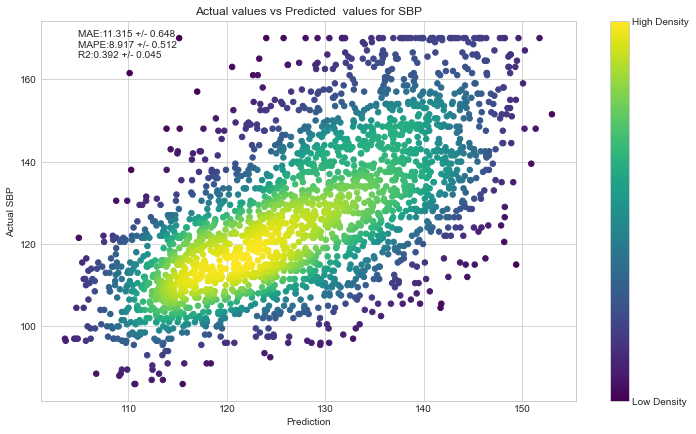

---------------------------------------------------------------------------------
Validation set


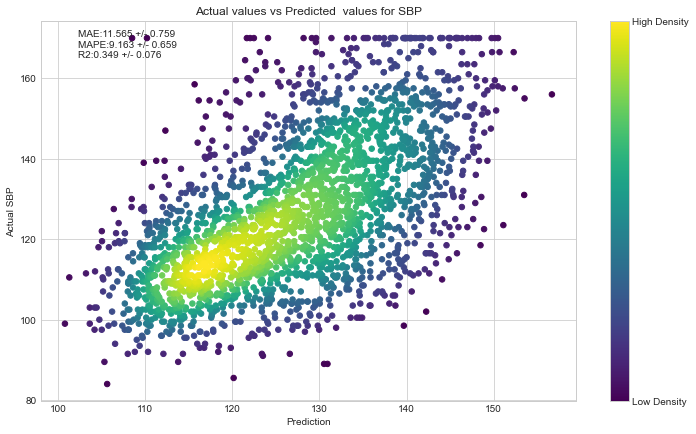

---------------------------------------------------------------------------------
SHAP plot


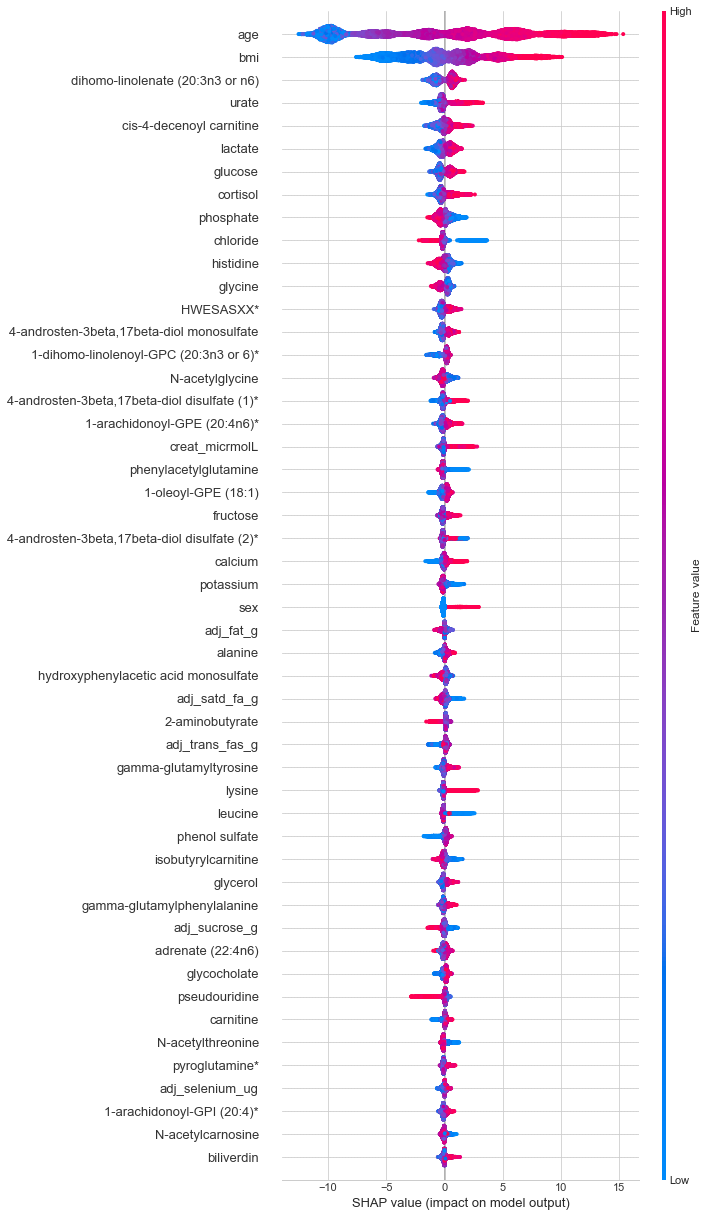

In [28]:
adj_columns = [e for e in adj_columns if e not in ('adj_energy_kj')]

Features = [*metabolites_columns, *adj_columns,'age','bmi','fid',*electrolytes_columns, 'sex','PRS','batch']

params= {'colsample_bytree': 0.943, 'min_child_weight': 197, 'learning_rate': 0.063, 'n_estimators': 137,
        'max_depth':6}

model = xgb.XGBRegressor(**params, objective ='reg:squarederror',n_jobs=-1)

X_SHAP, shap_values = test_model_cross_validation(model, Features, 5, selected_data, names_data, target='SBP', output_SHAP=True)

### Extract the feature importance list

In [28]:
di = {}
for m in X_SHAP.columns[X_SHAP.columns.str.startswith('M')]:
    try:
        di[m] = names_data[names_data['metabolon.id']==m]['name'].values[0]
    except:
        di[m] = m

X_SHAP_names = X_SHAP[Features].rename(columns=di)
X_SHAP_names = X_SHAP_names.drop('fid',axis=1)

vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_SHAP_names.columns,vals)),columns=['Features','Values'])
feature_importance.sort_values(by=['Values'],ascending=False,inplace=True)
feature_importance = feature_importance[feature_importance['Values']>0]

plot_df = feature_importance.iloc[:50,:]
plot_df = plot_df[~(plot_df['Features']=='fid')]
plot_df.reset_index().drop('index', axis=1)

,Features,Values
0,age,6.061342
1,bmi,2.884937
2,dihomo-linolenate (20:3n3 or n6),0.722758
3,urate,0.597189
4,cis-4-decenoyl carnitine,0.477192
5,lactate,0.472049
6,glucose,0.464634
7,cortisol,0.448201
8,phosphate,0.446718
9,chloride,0.373496


### Repeat the same thing but without replacing metabolites' names. These will be used for PCA later

In [29]:
X_SHAP_pca = X_SHAP[Features]
X_SHAP_pca = X_SHAP_pca.drop('fid',axis=1)
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_SHAP_pca.columns,vals)),columns=['Features','Values'])
feature_importance.sort_values(by=['Values'],ascending=False,inplace=True)
feature_importance = feature_importance[feature_importance['Values']>0]

pca_df = feature_importance.iloc[:50,:]

# Check the percentage of missingness of the top 50 features

In [33]:
missing_data_df = pre_imputed_data[['age', 'bmi', 'M35718', 'M01604', 'M38178', 'M00527', 'M20489',
       'M01712', 'M11438', 'chloride', 'M00059', 'M32338', 'M32836',
       'M17807', 'M33821', 'M27710', 'M37202', 'M35186', 'creat_micrmolL',
       'M35126', 'M35628', 'M00577', 'M37203', 'calcium', 'potassium',
       'sex', 'adj_fat_g', 'M32339', 'M34306', 'adj_satd_fa_g', 'M32348',
       'adj_trans_fas_g', 'M02734', 'M01301', 'M00060', 'M32553',
       'M33441', 'M15122', 'M33422', 'adj_sucrose_g', 'M32980', 'M18476',
       'M33442', 'M15500', 'M33939', 'M32672', 'adj_selenium_ug',
       'M34214', 'M33666', 'M02137']]

pct_missing_list = []
for col in missing_data_df.columns:
    pct_missing = np.mean(missing_data_df[col].isna())
    pct_missing_list.append(pct_missing)

pct_missing_df = pd.DataFrame({'Features':missing_data_df.columns, 'Percentage missing':pct_missing_list})
print('Overall average missingness: {}'.format(pct_missing_df['Percentage missing'].mean()))
pct_missing_df

Overall average missingness: 0.03832202344231955


,Features,Percentage missing
0,age,0.000000
1,bmi,0.003701
2,M35718,0.000000
3,M01604,0.000000
4,M38178,0.191240
5,M00527,0.000000
6,M20489,0.000000
7,M01712,0.000000
8,M11438,0.000000
9,chloride,0.085133


# Test the model without family ID

In [33]:
adj_columns = [e for e in adj_columns if e not in ('adj_energy_kj')]

Features = [*metabolites_columns, *adj_columns,'age','bmi',*electrolytes_columns, 'sex','PRS','batch']

params= {'colsample_bytree': 0.943, 'min_child_weight': 197, 'learning_rate': 0.063, 'n_estimators': 137,
        'max_depth':6}

model = xgb.XGBRegressor(**params, objective ='reg:squarederror',n_jobs=-1)

test_model_cross_validation(model, Features, 5, selected_data, names_data, target='SBP', pics=False)

Test set: MAE = 11.451 +/- 0.683, MAPE = 9.060 +/- 0.601, R2 = 0.371 +/- 0.056
Validation set: MAE = 11.635 +/- 0.823, MAPE = 9.237 +/- 0.732, R2 = 0.337 +/- 0.062


# Test the female-only model

In [32]:

Features = [*metabolites_columns, *adj_columns,'age','bmi','fid',*electrolytes_columns, 'PRS','batch']

params= {'colsample_bytree': 0.943, 'min_child_weight': 197, 'learning_rate': 0.063, 'n_estimators': 137,
        'max_depth':6}

model = xgb.XGBRegressor(**params, objective ='reg:squarederror',n_jobs=-1)
gss = GroupShuffleSplit(n_splits=5, random_state=0)

female_only_data = selected_data[selected_data['sex']==0].reset_index(drop=True)

test_model_cross_validation(model, Features, 5, female_only_data, names_data, target='SBP', pics=False)

Test set: MAE = 11.43 +/- 0.912, MAPE = 9.041 +/- 0.686, R2 = 0.335 +/- 0.077
Validation set: MAE = 11.891 +/- 1.115, MAPE = 9.375 +/- 0.743, R2 = 0.302 +/- 0.091


# Repeat the same process for DBP

Test set: MAE = 7.422 +/- 0.266, MAPE = 9.808 +/- 0.438, R2 = 0.207 +/- 0.031
Validation set: MAE = 7.195 +/- 0.667, MAPE = 9.499 +/- 0.967, R2 = 0.177 +/- 0.084
---------------------------------------------------------------------------------
Test set


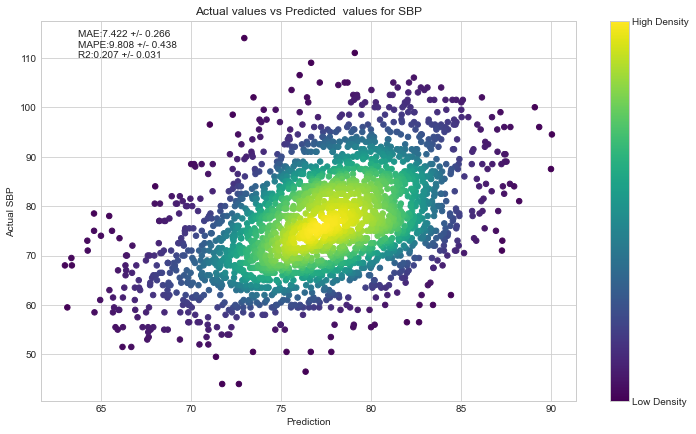

---------------------------------------------------------------------------------
Validation set


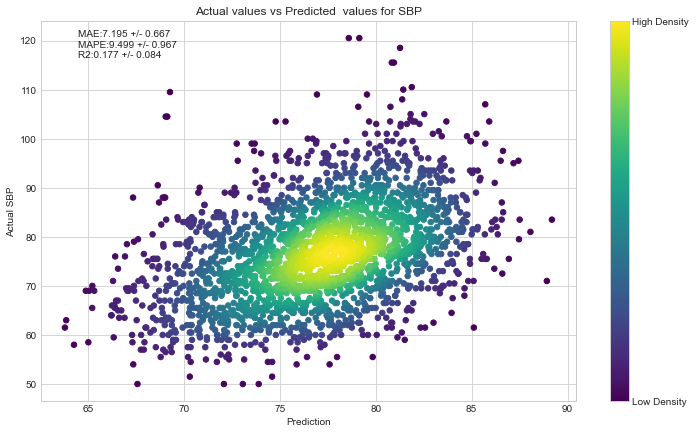

---------------------------------------------------------------------------------
SHAP plot


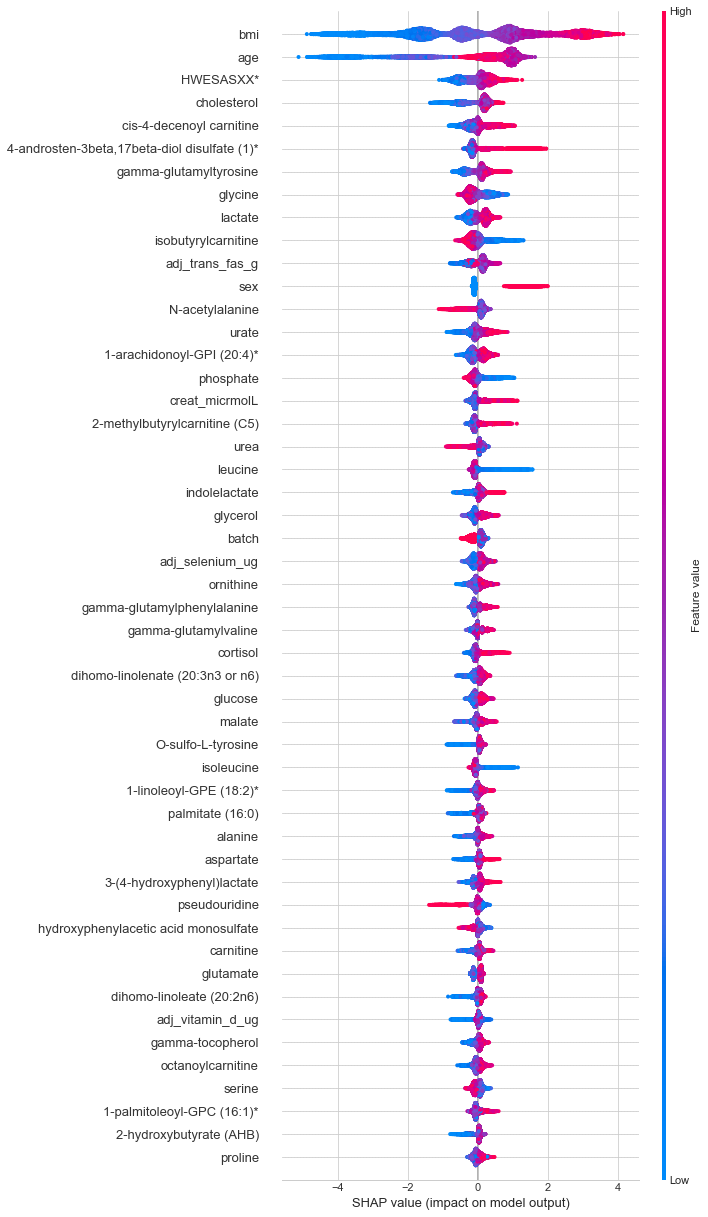

In [44]:

Features = [*metabolites_columns, *adj_columns,'age','bmi','fid',*electrolytes_columns, 'sex','PRS','batch']

params= {'colsample_bytree': 0.277, 'min_child_weight': 197, 'learning_rate': 0.063, 'n_estimators': 137,
        'max_depth':6}

model = xgb.XGBRegressor(**params, objective ='reg:squarederror',n_jobs=-1)
gss = GroupShuffleSplit(n_splits=5, random_state=0)

test_model_cross_validation(model, Features, 5, selected_data, names_data, target='DBP')

# PCA

In [32]:
fea_to_use = [e for e in pca_df['Features'].values if e not in ('adj_energy_kj','fid')]
df_full = selected_data[[*fea_to_use, 'SBP']]
df_pca = df_full.drop('SBP',axis=1)

### Add the pathways info to the features dataframe

In [33]:
df_temp = df_pca.transpose().reset_index()

def add_pathway(data, names_data):
    try:
        pathway = names_data[names_data['metabolon.id']==data['index']]['super.pathway'].values[0]
    except:
        pathway = data['index']
    return pathway

df_temp['pathway'] = df_temp.apply(add_pathway,
                      names_data=names_data,
                      axis=1,
                      result_type="expand")

## Merge adjusted trans fat & adjusted fat as 1 pathway 

## Encode the pathway as numerical values

In [34]:
df_temp['pathway'] = df_temp['pathway'].replace(['adj_trans_fas_g', 'adj_fat_g'],'diet_fat')
le = preprocessing.LabelEncoder()
df_temp['pathway'] = le.fit_transform(df_temp['pathway'])
df_temp = df_temp.set_index('index')
df_temp = df_temp.transpose()

## Apply PCA, plot the PCA components' coefficients as a biplot

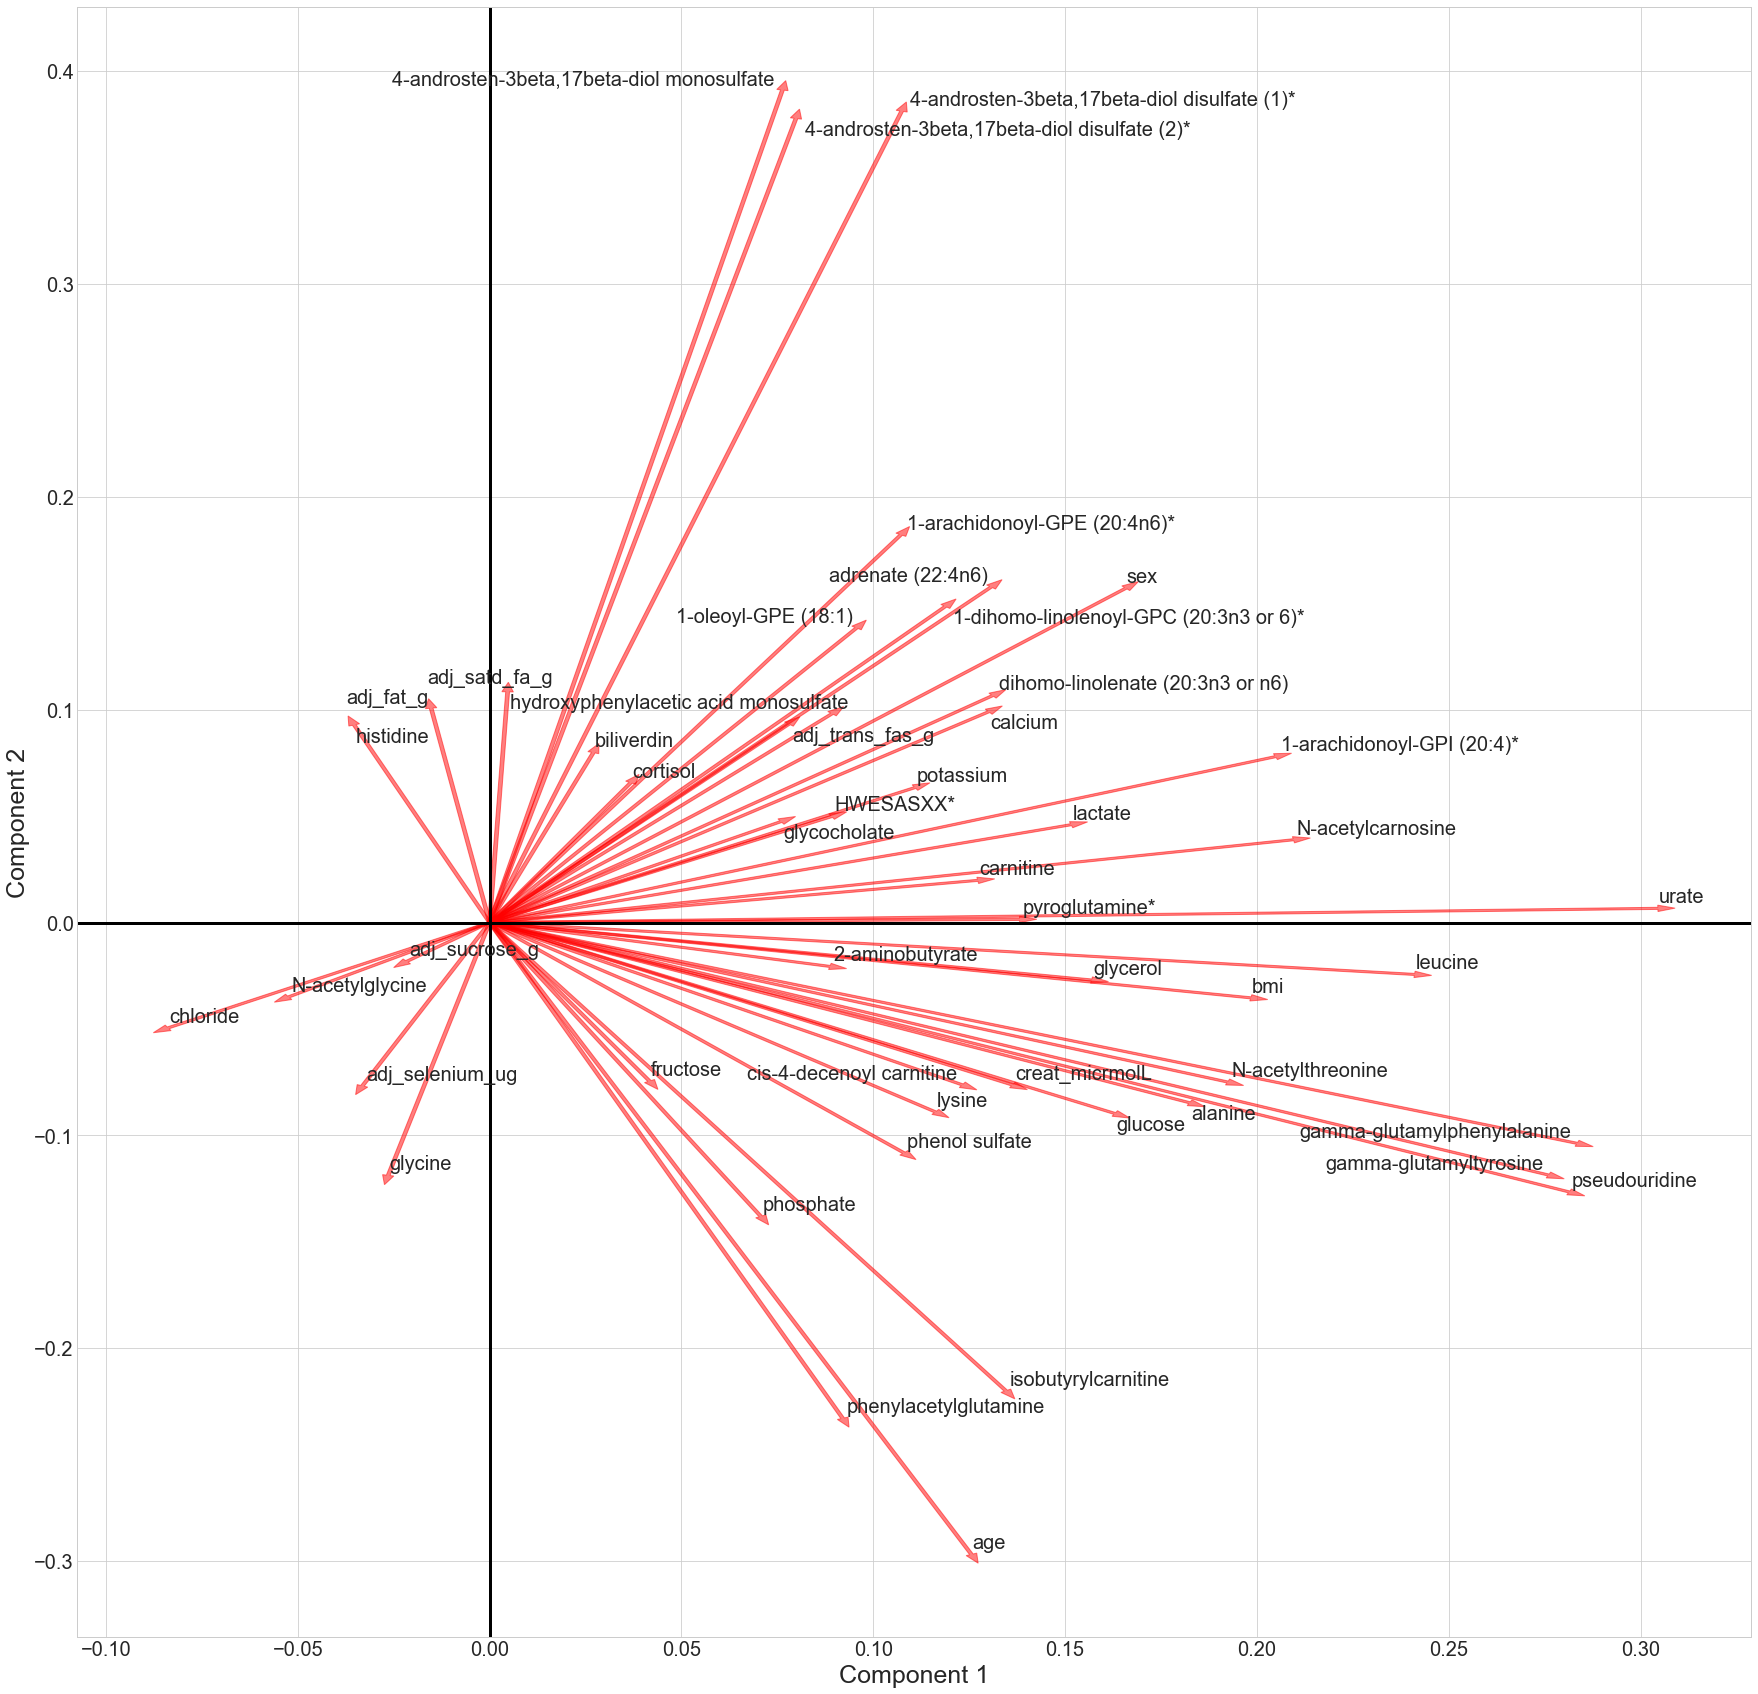

In [35]:
scaler = StandardScaler()
scaler.fit(df_temp)
X=scaler.transform(df_temp)    
pca = PCA()
x_new = pca.fit_transform(X)
x_new = pd.DataFrame(x_new, columns = df_temp.columns)
x_new = x_new.rename(columns=di)

def myplot(score,coeff,labels=None):
    plt.figure(figsize = (30,30))
    xs = score.iloc[:,0]
    ys = score.iloc[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    texts = []
    
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],alpha = 0.5, color = 'red')
        texts.append(plt.text(coeff[i,0], coeff[i,1], labels[i], ha = 'center', va = 'center', fontsize=(20)))
    
    plt.axvline(x=0, color ='black', linewidth=3)
    plt.axhline(y=0, color = 'black', linewidth=3)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    adjust_text(texts)
    plt.xticks(size=20)
    plt.yticks(size=20)
    plt.xlabel("Component 1", fontsize=25)
    plt.ylabel("Component 2", fontsize=25)
    plt.show()
    
    
#Call the function. Use only the 2 PCs.
myplot(x_new.iloc[:,0:2],np.transpose(pca.components_[0:2, :]), labels = x_new.columns)

# Step-wise incremental testing

###  Traditional risk factors (age, sex, bmi) only

In [29]:
Features = ['age','bmi','sex','fid']

params= {'colsample_bytree': 0.943, 'min_child_weight': 197, 'learning_rate': 0.063, 'n_estimators': 137,
        'max_depth':6}

model = xgb.XGBRegressor(**params, objective ='reg:squarederror',n_jobs=-1)

test_model_cross_validation(model, Features, 5, selected_data, names_data, target='SBP', pics=False)

Test set: MAE = 11.991 +/- 0.395, MAPE = 9.462 +/- 0.169, R2 = 0.33 +/- 0.015
Validation set: MAE = 12.094 +/- 0.7, MAPE = 9.599 +/- 0.691, R2 = 0.292 +/- 0.081


###  Demo graphics + urate + lactate + glucose + cortisol + creat + calcium + potassium + phosphate + sodium

In [50]:
Features = ['age','bmi','fid','sex','M01604','M00527','M20489','M01712', 'creat_micrmolL','calcium',
 'phosphate', 'sodium','potassium','chloride']

params= {'colsample_bytree': 0.943, 'min_child_weight': 81, 'learning_rate': 0.057, 'n_estimators': 103,
        'max_depth':6}

model = xgb.XGBRegressor(**params, objective ='reg:squarederror',n_jobs=-1)

test_model_cross_validation(model, Features, 5, selected_data, names_data, target='SBP', pics=False)

Test set: MAE = 11.488 +/- 0.379, MAPE = 9.028 +/- 0.291, R2 = 0.378 +/- 0.022
Validation set: MAE = 11.609 +/- 0.962, MAPE = 9.178 +/- 0.797, R2 = 0.337 +/- 0.091


## Previous + metabolites

In [51]:
Features = ['age','bmi','fid','sex',*metabolites_columns, 'creat_micrmolL','calcium','phosphate', 'sodium','potassium']

params= {'colsample_bytree': 0.975, 'min_child_weight': 187, 'learning_rate': 0.06, 'n_estimators': 114,
        'max_depth':6}

model = xgb.XGBRegressor(**params, objective ='reg:squarederror',n_jobs=-1)

test_model_cross_validation(model, Features, 5, selected_data, names_data, target='SBP', pics=False)

Test set: MAE = 11.355 +/- 0.586, MAPE = 8.946 +/- 0.443, R2 = 0.388 +/- 0.036
Validation set: MAE = 11.601 +/- 0.774, MAPE = 9.181 +/- 0.624, R2 = 0.349 +/- 0.076


# All previous + nutritions

In [52]:
Features = ['age','bmi','fid','sex',*metabolites_columns, 'creat_micrmolL','calcium','phosphate', 'sodium',
 'potassium', 'adj_selenium_ug', 'adj_fat_g', 'adj_sucrose_g','adj_satd_fa_g', 'adj_trans_fas_g', 'chloride']

params= {'colsample_bytree': 0.829,'min_child_weight': 116,'learning_rate': 0.049,'n_estimators': 165,'max_depth':6}

model = xgb.XGBRegressor(**params, objective ='reg:squarederror',n_jobs=-1)

test_model_cross_validation(model, Features, 5, selected_data, names_data, target='SBP', pics=False)

Test set: MAE = 11.342 +/- 0.348, MAPE = 8.937 +/- 0.261, R2 = 0.389 +/- 0.022
Validation set: MAE = 11.578 +/- 0.819, MAPE = 9.174 +/- 0.667, R2 = 0.349 +/- 0.078
